In [2]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net

In [3]:
import pickle

import importlib
importlib.reload(misc)

In [4]:

from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn as nn
from mnist import MNIST

mnist = MNIST('/home/orram/Documents/datasets/MNIST/')
images, labels = mnist.load_training()

# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

In [5]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


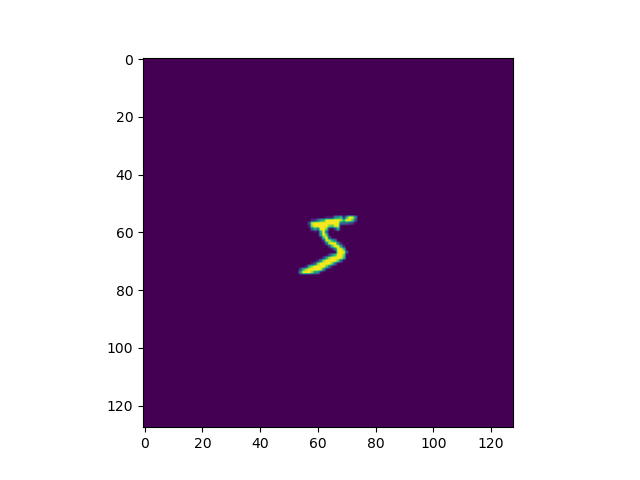

In [6]:
plt.figure()
plt.imshow(misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28])))

In [7]:
img=misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28]))

In [8]:
import SYCLOP_env as syc

In [9]:
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    return upsmp
    

In [10]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [11]:
q_sequence = [[agent.max_q[0]//2, qq ] for qq in np.arange(agent.max_q[1]//2-10,agent.max_q[1]//2+10)]
q_sequence = np.array(q_sequence)

In [12]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(15,15))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(70):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


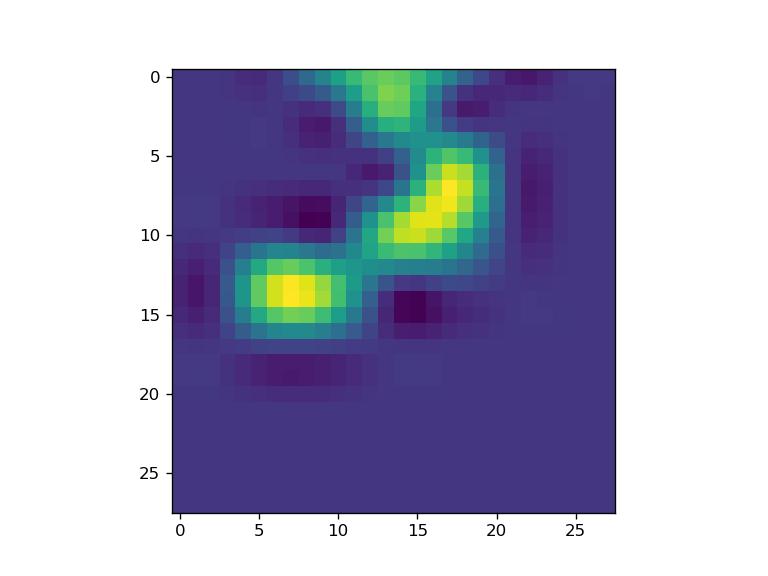

<IPython.core.display.Javascript object>


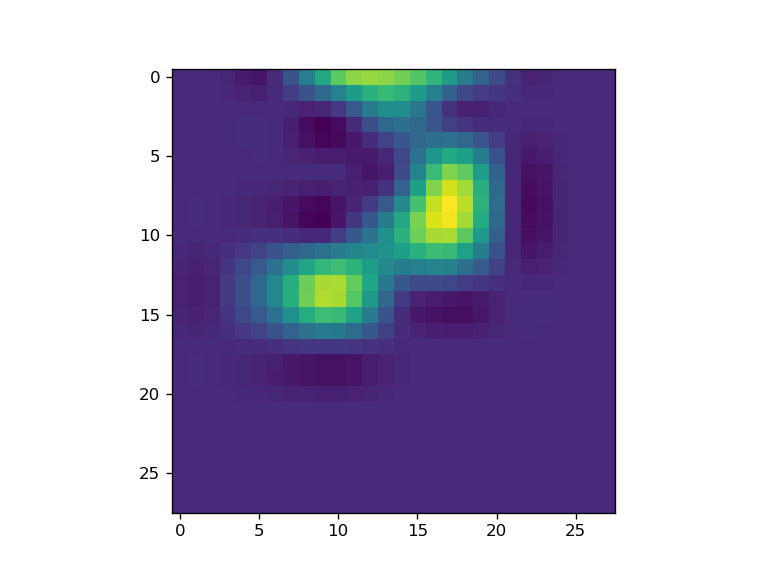

<IPython.core.display.Javascript object>


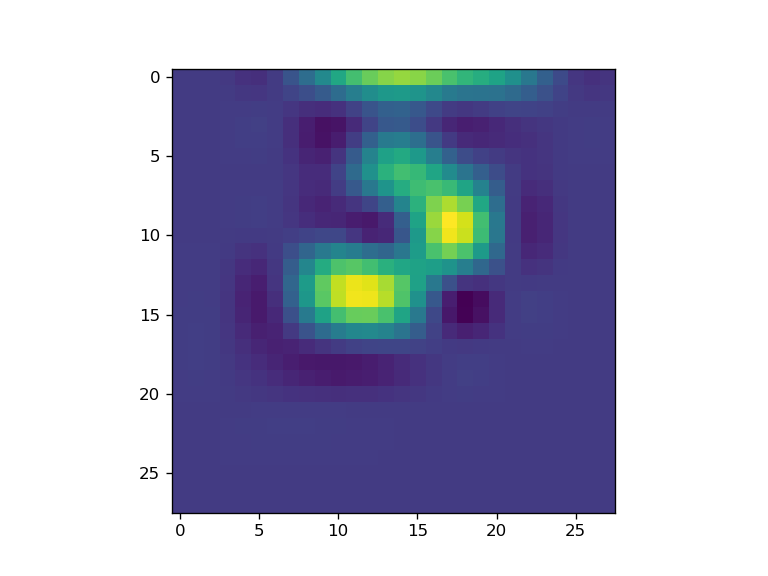

<IPython.core.display.Javascript object>


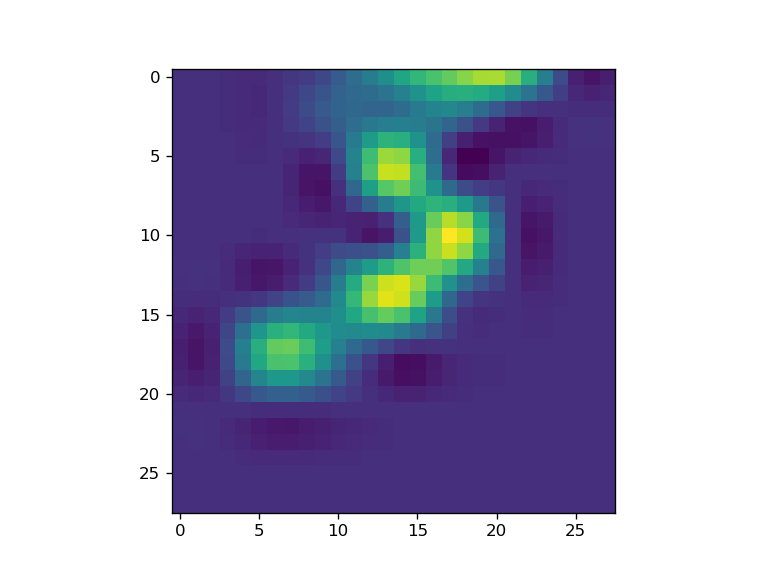

<IPython.core.display.Javascript object>


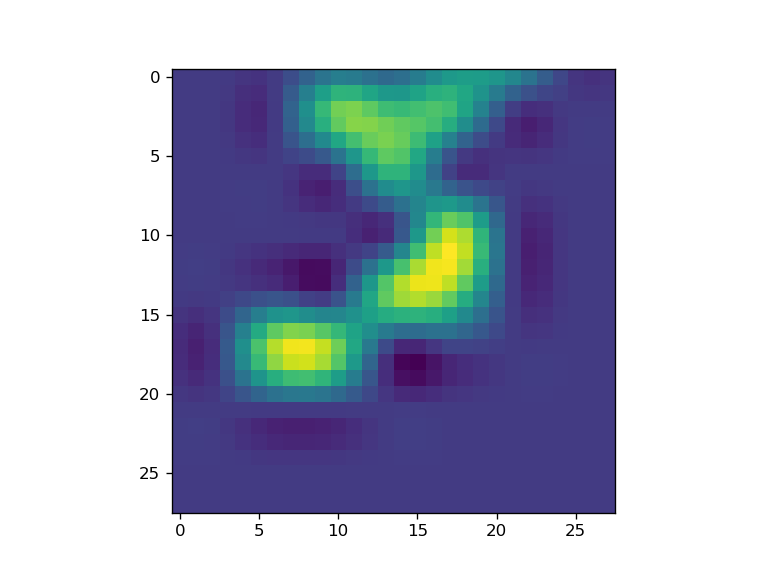

<IPython.core.display.Javascript object>


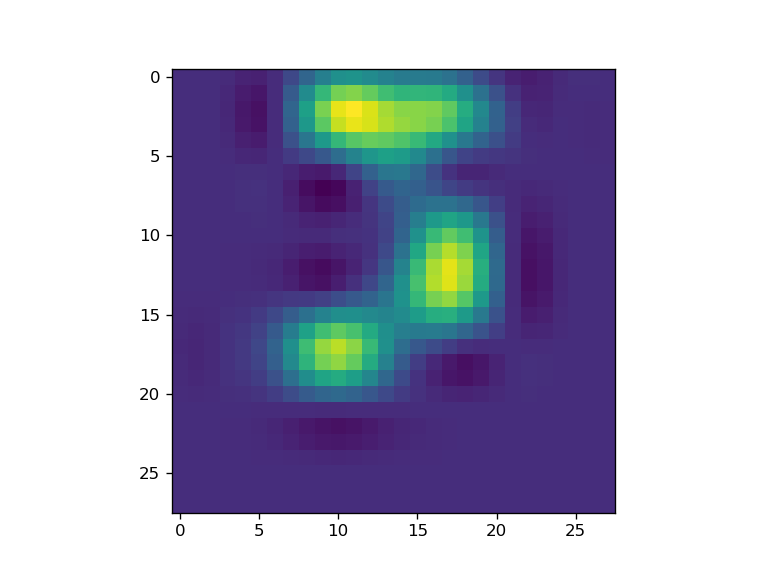

<IPython.core.display.Javascript object>


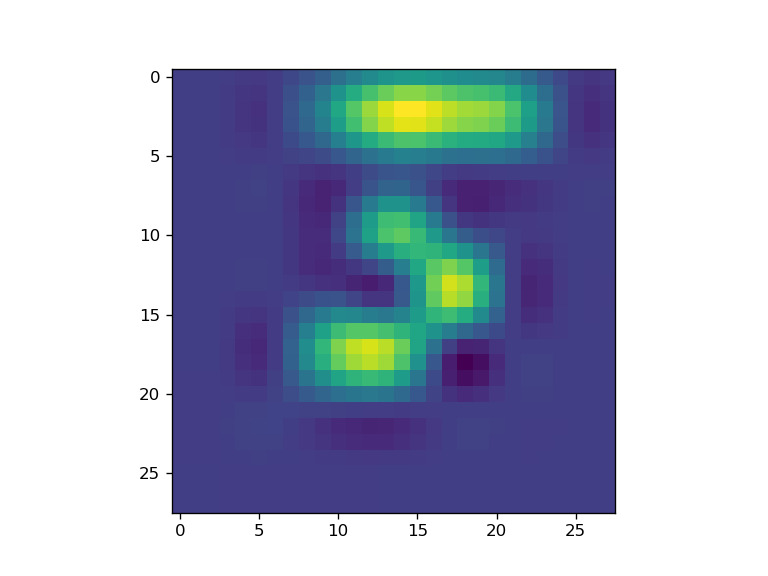

<IPython.core.display.Javascript object>


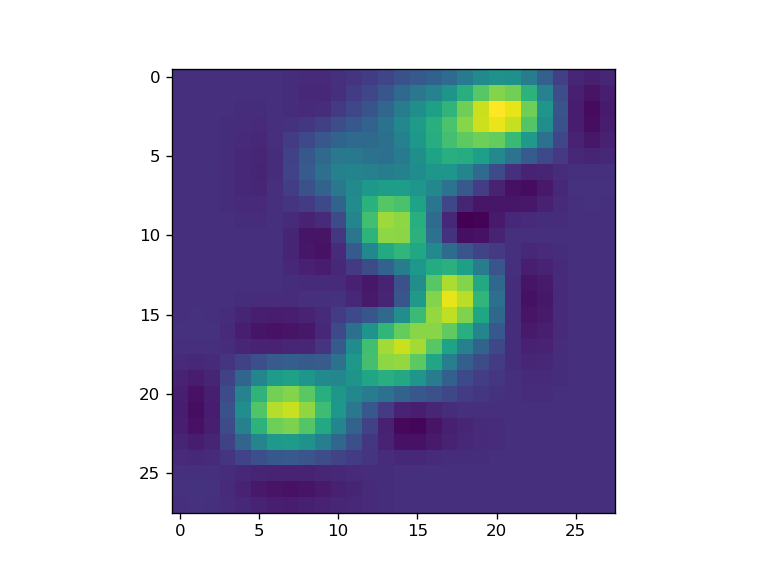

<IPython.core.display.Javascript object>


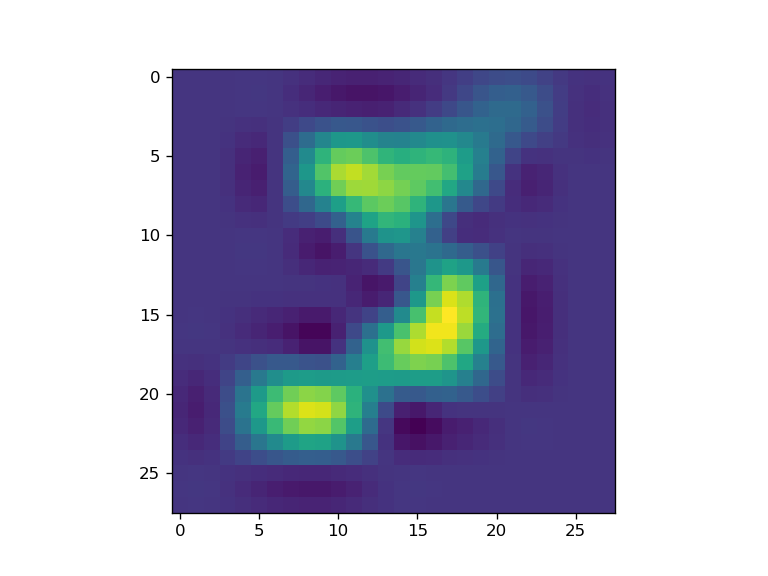

<IPython.core.display.Javascript object>


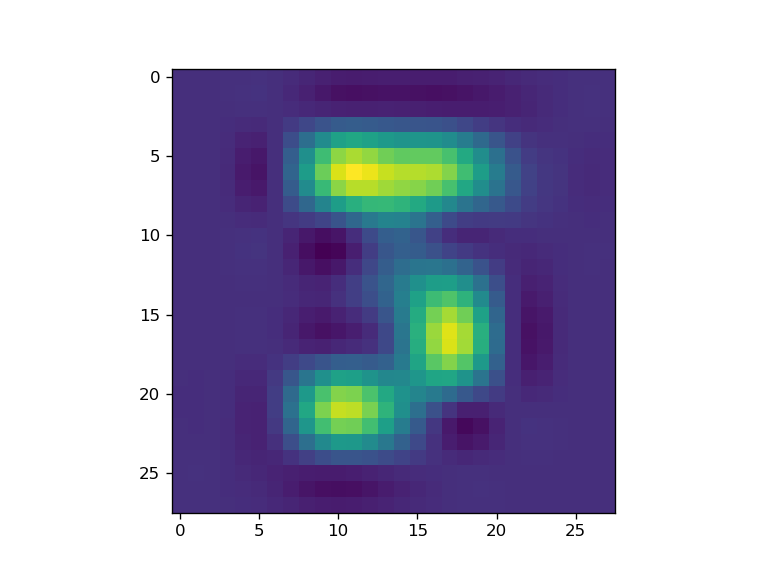

<IPython.core.display.Javascript object>


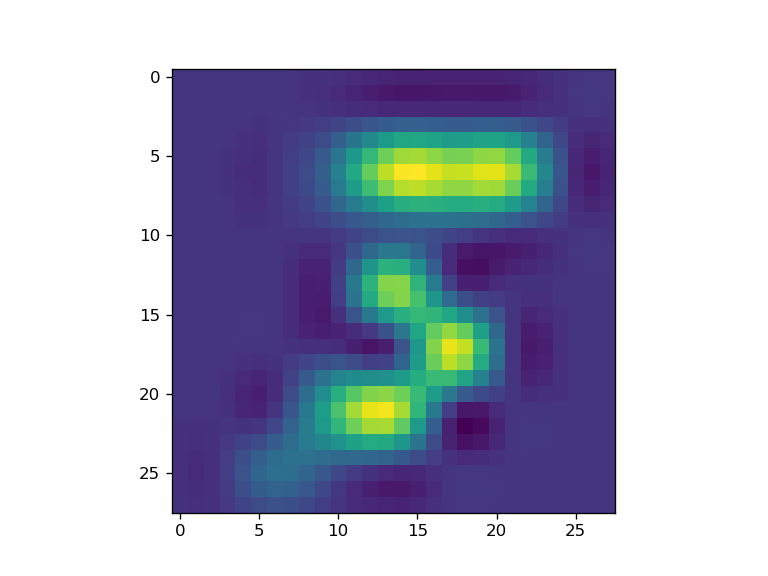

<IPython.core.display.Javascript object>


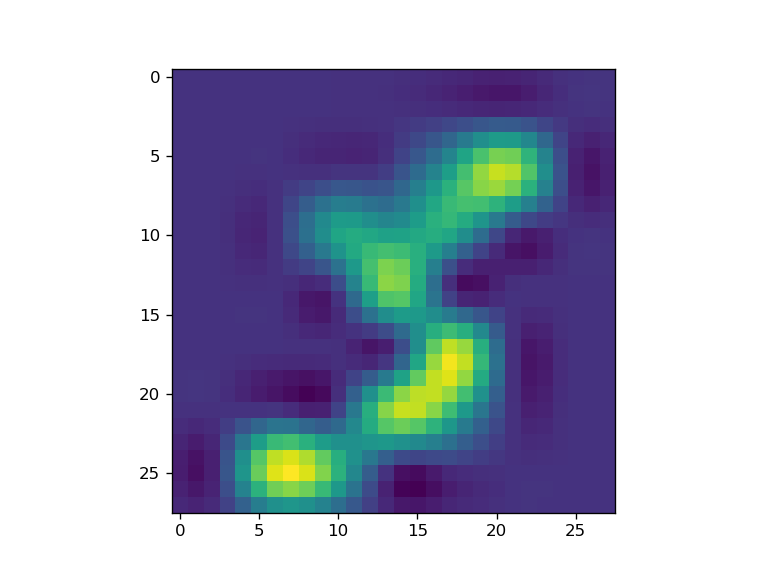

<IPython.core.display.Javascript object>


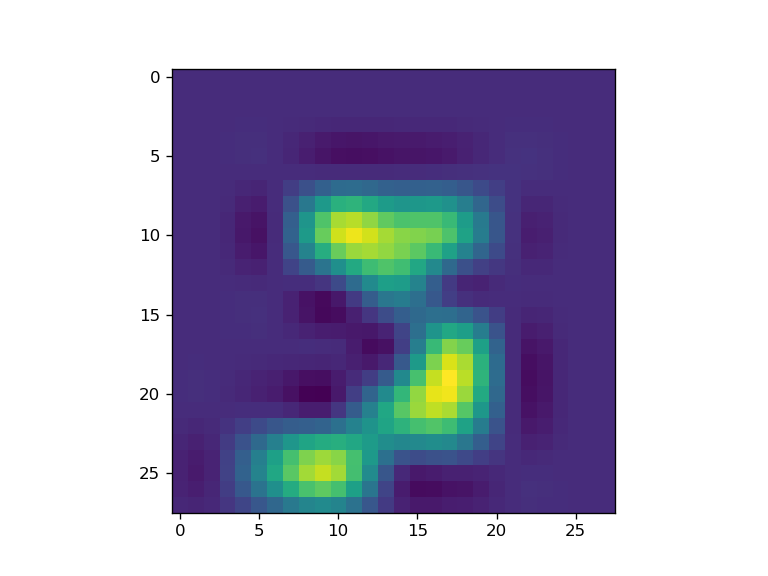

<IPython.core.display.Javascript object>


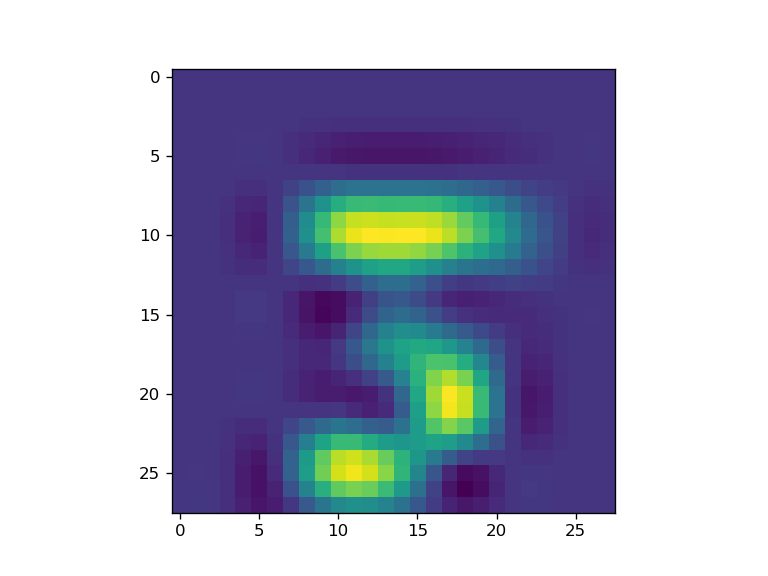

<IPython.core.display.Javascript object>


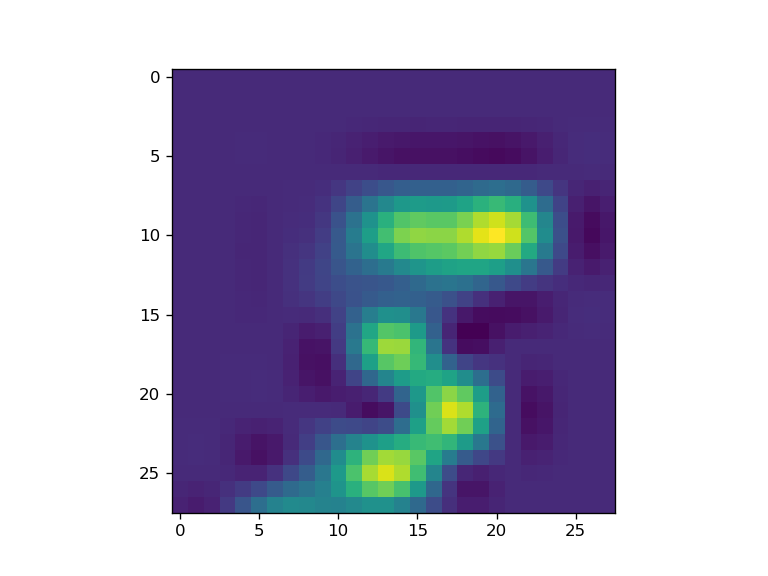

<IPython.core.display.Javascript object>


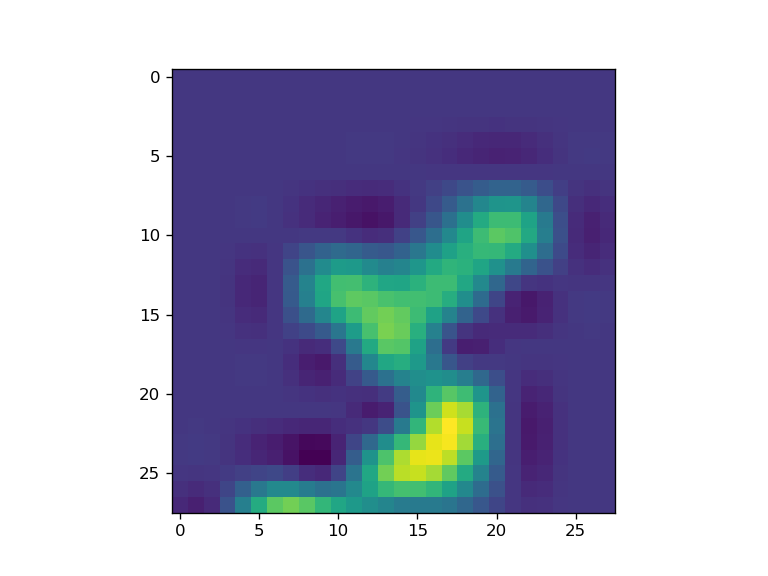

<IPython.core.display.Javascript object>


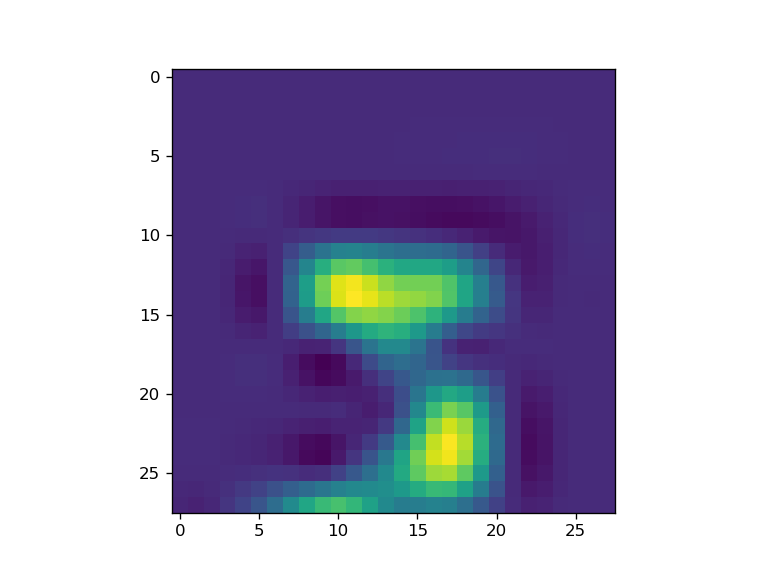

<IPython.core.display.Javascript object>


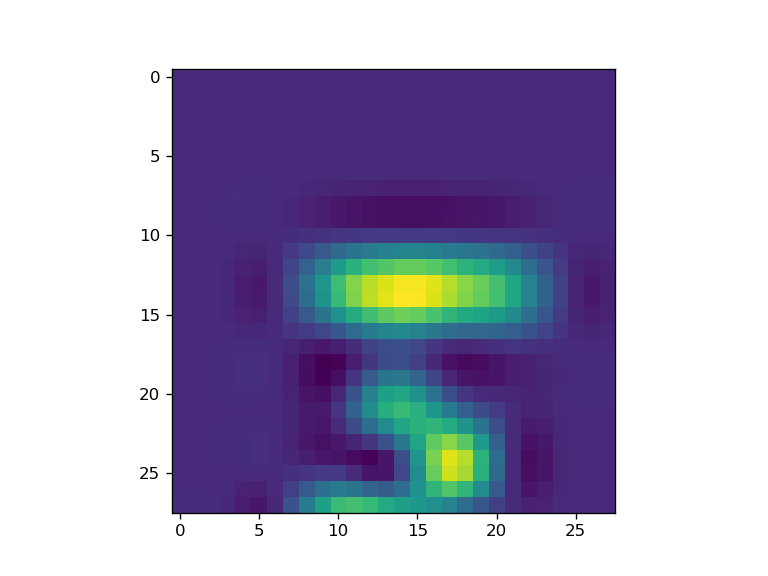

<IPython.core.display.Javascript object>


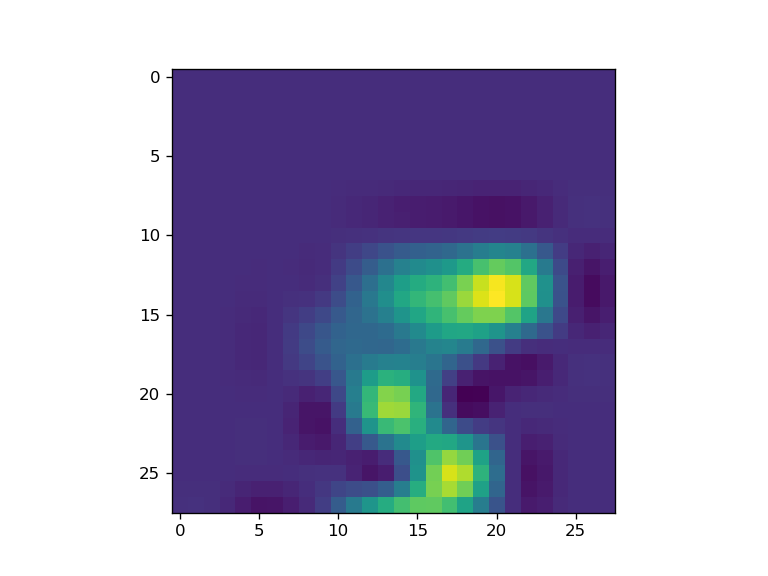

<IPython.core.display.Javascript object>


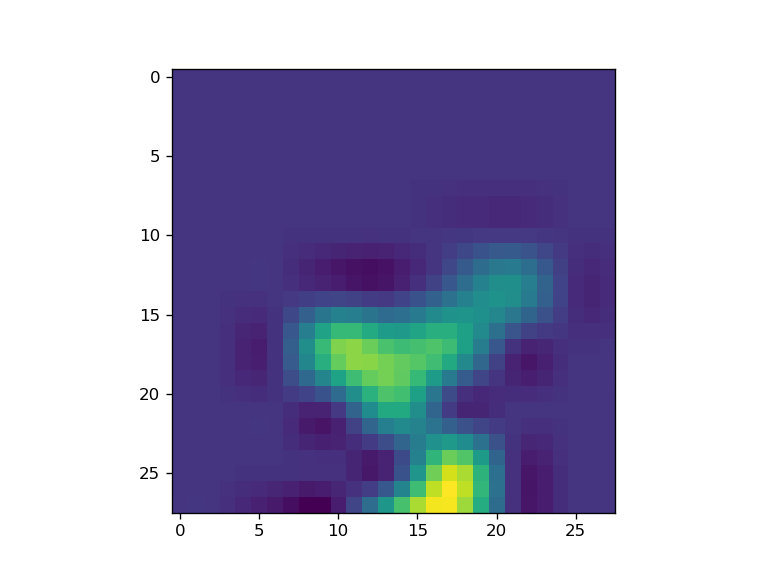

In [14]:
for i in range(20):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10)
<br> 

In [76]:
def create_dataset(images, labels, res):
    count = 0
    ts_images = []
    dvs_images = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img in images:
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        q_sequence = [[agent.max_q[0]//2, qq ] for qq in np.arange(agent.max_q[1]//2-10,agent.max_q[1]//2+10,4)]
        q_sequence = np.array(q_sequence)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[-3]) 
            plt.title(labels[count])
            i+=1

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        count += 1
        


    ts_train = ts_images[:55_000]
    train_labels = labels[:55_000]
    ts_val = ts_images[55_000:]
    val_labels = labels[55_000:]

    dvs_train = dvs_images[:55_000]
    dvs_val = dvs_images[55_000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, transform = None):

            self.data = data
            self.labels = labels

            self.transform = transform
        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            data = self.data[idx]
            label = self.labels[idx]

            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels



    train_dataset = mnist_dataset(ts_train, train_labels)
    test_dataset = mnist_dataset(ts_val, val_labels)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    
    return train_dataloader, test_dataloader



<IPython.core.display.Javascript object>


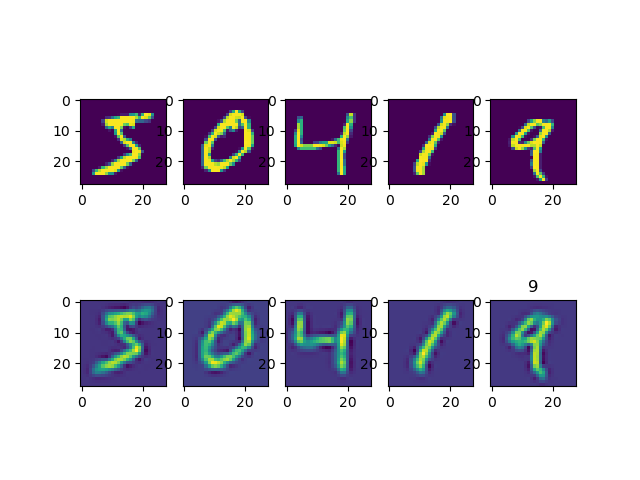

In [77]:
train_dataloader, test_dataloader = create_dataset(images, labels,res = 28)

55040

In [5]:
import joblib
#_, labels = mnist.load_training()
ts_train = joblib.load('ts_train')
train_labels = joblib.load('ts_labels')
ts_val = joblib.load('ts_val')
val_labels = joblib.load('ts_val_train')


In [32]:
train_labels = labels[:55_000]
val_labels = labels[55_000:]


55000

In [68]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(5,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [82]:
def train(train_dataloader, test_dataloader, net, epochs = 10):
    epochs = 26
    lr = 3e-3
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()

    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct/len(test_targets))
            print('Epoch : ',epoch+1, '\t', 'loss :', loss.item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    
    return train_loss, test_loss, test_accur

In [ ]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN().double(), epochs = 10)

Epoch :  1 	 loss : 0.0036054863503714426 accuracy : 98.35838
Epoch :  2 	 loss : 0.0040401160941936675 accuracy : 98.595726
Epoch :  3 	 loss : 0.00031494610723965116 accuracy : 98.83307
Epoch :  4 	 loss : 0.0006169751918050477 accuracy : 98.49683
Epoch :  5 	 loss : 0.003921160018527747 accuracy : 98.8924
Epoch :  6 	 loss : 0.00024244145213027818 accuracy : 98.81329
Epoch :  7 	 loss : 0.012854687226184193 accuracy : 98.773735
Epoch :  8 	 loss : 9.7649221751385e-06 accuracy : 98.951744
Epoch :  9 	 loss : 0.0002066743056163283 accuracy : 98.93196
Epoch :  10 	 loss : 0.00015807866860962464 accuracy : 99.05064
Epoch :  11 	 loss : 0.0001022294801424778 accuracy : 98.75395
Epoch :  12 	 loss : 4.175690740831275e-05 accuracy : 99.09019
Epoch :  13 	 loss : 2.2684370469810116e-06 accuracy : 98.93196
Epoch :  14 	 loss : 4.630363563719746e-07 accuracy : 98.47706
Epoch :  15 	 loss : 0.0008445229246537463 accuracy : 98.73418
Epoch :  16 	 loss : 2.9500114593734957e-06 accuracy : 98.9912

### Regular conv net with regular data stacked works as well with more then 99% accuracy - let's push it into an RNN and see that we replecate the resilts before moving to lower resolutions. 

In [79]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        hn = torch.zeros([1,data.shape[0],100]).double()
        for i in range(data.shape[1]):
            img = data[:,i,:,:,:]
            #plt.figure()
            #plt.imshow(img[0][0])
            img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
            img = self.pool(self.relu(self.bn2(self.conv2(img))))
            img = self.relu(self.bn3(self.conv3(img)))        
            img = img.view(img.shape[0],8*8*16)
            out, hn = self.gru(img.unsqueeze(0),hn)
            #print(out.shape)
        output = self.fc1(out[0, :, :])
        
        
        return output

In [80]:
class RNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100, batch_first=True)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        batch_size, timesteps, C, H, W = data.size()
        img = datax.view(batch_size * timesteps, C, H, W)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        print(img.shape)
        img = img.view(img.shape[0],img.shape[1],8*8*16)
        out, hn = self.gru(img)
        output = self.fc1(hn.squeeze(0))
        
        
        return output

In [38]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net().double(), epochs = 10)

Epoch :  1 	 loss : 0.004265323125684652 accuracy : 98.912186
Epoch :  2 	 loss : 0.020991770685789404 accuracy : 99.03085
Epoch :  3 	 loss : 0.5524997304981456 accuracy : 98.85285
Epoch :  4 	 loss : 0.09526686410688172 accuracy : 99.129745
Epoch :  5 	 loss : 0.00017887853745292805 accuracy : 98.75395
Epoch :  6 	 loss : 0.0010102674777342335 accuracy : 99.01108


### Mooving on to lower resolutions 